In [143]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.attribute import NamePattern
from epymorph.kit import *

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck,ExponentialTransform
from epymorph.forecasting.pipeline import (ParticleFilterSimulator,
EnsembleKalmanFilterSimulator,
Observations,
ModelLink,
PipelineConfig,
UnknownParam)
from epymorph.forecasting.likelihood import Poisson

In [144]:
from typing_extensions import override
from epymorph.initializer import _POPULATION_ATTR
from epymorph.initializer import *


class RandomLocationsAndRandomSeed(SeededInfection):
    """
    Seed an random number of infected in a number of randomly selected locations.

    Requires "population" as a data attribute.

    Parameters
    ----------
    num_locations :
        The number of locations to choose.
    seed_max :
        The maximum number of individuals to infect.
    initial_compartment :
        Which compartment (by index or name) is "not infected", where most individuals
        start out.
    infection_compartment :
        Which compartment (by index or name) will be seeded as the initial infection.
    """

    requirements = (_POPULATION_ATTR,)

    num_locations: int
    """The number of locations to choose (randomly)."""
    seed_max: int
    """The maximum number of individuals to infect, drawn uniformly on [0,seed_max]."""

    def __init__(
        self,
        num_locations: int,
        seed_max: int,
        initial_compartment: int | str = SeededInfection.DEFAULT_INITIAL,
        infection_compartment: int | str = SeededInfection.DEFAULT_INFECTION,
    ):
        super().__init__(initial_compartment, infection_compartment)
        self.num_locations = num_locations
        self.seed_max = seed_max

    @override
    def evaluate(self) -> SimArray:
        """
        Evaluate the initializer in the current context.

        Returns
        -------
        :
            The initial populations for each node and IPM compartment.
        """
        N = self.scope.nodes
        if not 0 < self.num_locations <= N:
            err = (
                "Initializer argument 'num_locations' must be "
                f"a value from 1 up to the number of locations ({N})."
            )
            raise InitError(err)

        indices = np.arange(N, dtype=np.intp)
        selection = self.rng.choice(indices, self.num_locations)
        seed_size = self.rng.integers(low=0, high=self.seed_max, endpoint=True)

        sub = IndexedLocations(
            selection=selection,
            seed_size=seed_size,
            initial_compartment=self.initial_compartment,
            infection_compartment=self.infection_compartment,
        )
        return self.defer(sub)

In [145]:
scope = CountyScope.in_states(['AZ'],year=2015)
sim_movement_model = mm.Centroids()
sim_ipm = ipm.SIRH()
sim_time_frame = TimeFrame.of("2015-01-01", 26 * 7)
my_rng = np.random.default_rng(0)

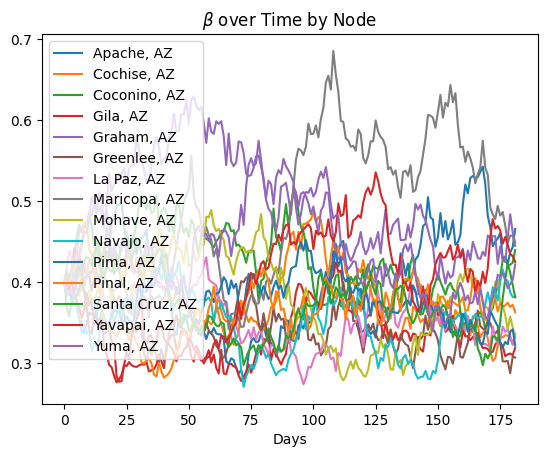

In [146]:
'''Generate a random time dependent beta'''
log_beta_damping = 1/35 * np.ones(scope.nodes)
log_beta_mean = np.log(0.4) * np.ones(scope.nodes)
log_beta_standard_deviation = 0.15 * np.ones(scope.nodes)
initial_log_beta = np.log(0.4) * np.ones(scope.nodes)

delta_t = 1. 

A = np.exp(-log_beta_damping * delta_t)
M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

log_beta = np.zeros((scope.nodes,sim_time_frame.duration_days,))
log_beta[:,0] = initial_log_beta

for day in range(1,sim_time_frame.duration_days): 
    log_beta[:,day] = A * log_beta[:,day-1] - M + C * my_rng.normal(size = (scope.nodes,))

beta = np.exp(log_beta)

plt.title('$\\beta$ over Time by Node')
plt.xlabel('Days')
for node in range(scope.nodes): 
    plt.plot(beta[node,:],label = f"{scope.labels[node]}")
plt.legend()
plt.show()

In [147]:
rume = SingleStrataRUME.build(
    ipm=sim_ipm,
    mm=sim_movement_model,
    scope= scope,
    init=init.IndexedLocations(selection=np.arange(scope.nodes),seed_size = 10_000),
    time_frame=sim_time_frame,
    params={
        "beta": beta.T,
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "label":us_tiger.Name()
    },
)

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.544s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-07-01 (182 days)
• 15 geo nodes
  |####################| 100%                     
Runtime: 0.556s


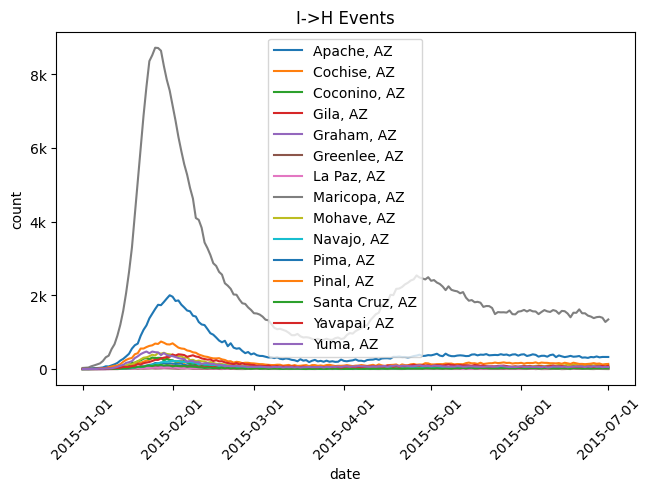

In [148]:
sim = BasicSimulator(rume)

with sim_messaging():
    out = sim.run(
        rng_factory=lambda : my_rng
    )

out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group('day').agg(),
    quantity=rume.ipm.select.events("I->H"),
    title="I->H Events",
    label_format="{n}",
    legend = "on"
)

In [149]:
from epymorph.adrio import csv
from epymorph.tools.data import munge

cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

cases_df.to_csv('./synthetic_data_comp.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='./synthetic_data_comp.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [150]:
my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all().group("day").agg(),
        quantity=rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson()
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}

In [154]:
num_realizations = 100

inf_rume = SingleStrataRUME.build(
    ipm=sim_ipm,
    mm=sim_movement_model,
    scope=scope,
    init=RandomLocationsAndRandomSeed(scope.nodes,50_000),
    time_frame=sim_time_frame,
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "label":us_tiger.Name()
    },
)

particle_filter_simulator = ParticleFilterSimulator(
    config=PipelineConfig.from_rume(
        inf_rume, num_realizations, unknown_params=my_unknown_params
    ),
    observations=my_observations,
)

In [155]:
particle_filter_output = particle_filter_simulator.run(rng=my_rng)

Observation: 0, Label: 2015-01-01, Time Frame: 2015-01-01 (1D)
Observation: 1, Label: 2015-01-02, Time Frame: 2015-01-02 (1D)
Observation: 2, Label: 2015-01-03, Time Frame: 2015-01-03 (1D)
Observation: 3, Label: 2015-01-04, Time Frame: 2015-01-04 (1D)
Observation: 4, Label: 2015-01-05, Time Frame: 2015-01-05 (1D)
Observation: 5, Label: 2015-01-06, Time Frame: 2015-01-06 (1D)
Observation: 6, Label: 2015-01-07, Time Frame: 2015-01-07 (1D)
Observation: 7, Label: 2015-01-08, Time Frame: 2015-01-08 (1D)
Observation: 8, Label: 2015-01-09, Time Frame: 2015-01-09 (1D)
Observation: 9, Label: 2015-01-10, Time Frame: 2015-01-10 (1D)
Observation: 10, Label: 2015-01-11, Time Frame: 2015-01-11 (1D)
Observation: 11, Label: 2015-01-12, Time Frame: 2015-01-12 (1D)
Observation: 12, Label: 2015-01-13, Time Frame: 2015-01-13 (1D)
Observation: 13, Label: 2015-01-14, Time Frame: 2015-01-14 (1D)
Observation: 14, Label: 2015-01-15, Time Frame: 2015-01-15 (1D)
Observation: 15, Label: 2015-01-16, Time Frame: 20

In [ ]:
from epymorph.compartment_model import (
    CompartmentDef,
    QuantityAggregation,
    QuantitySelection,
)
from epymorph.geography.scope import GeoAggregation, GeoSelection
from epymorph.rume import RUME
from epymorph.time import Dim, TimeAggregation, TimeSelection
from epymorph.util import mask

import pandas as pd

### Selections for munge
time = rume.time_frame.select.all().group("day").agg()
geo = rume.scope.select.all()
quantity = rume.ipm.select.compartments('I')

NP = particle_filter_output.num_realizations

### Sample realizations
sample_size = 10
sample_indices = my_rng.choice(np.arange(NP),size = sample_size)
#sample_indices = np.arange(NP)

N = particle_filter_output.rume.scope.nodes
S = particle_filter_output.rume.num_ticks
taus = particle_filter_output.rume.num_tau_steps

# Apply selections first so that aggregations operate on less data.
time_mask = np.tile(np.repeat(mask(S, time.selection_ticks(taus)), N),NP)
geo_mask = np.tile(np.tile(geo.selection, S),NP)

# columns are: ["tick", "date", "node", *quantities]
columns = np.concatenate(([True,True, True, True], quantity.selection))
data_df = particle_filter_output.dataframe
data_df = data_df.loc[time_mask & geo_mask].loc[:, columns]
data_df = data_df.set_axis(["realization","tick", "date", "geo", *data_df.columns[4:]], axis=1)
data_df = data_df.loc[data_df['realization'].isin(sample_indices)]

# I think it makes the most intuitive sense to apply time aggregation last.
# For example, if the user simulates at tract and wants the peak infection
# by county -- they probably want each county's peak to represent a single date,
# rather than summing tract peaks from different days.

if geo.aggregation is None:
    # Without agg: use node IDs as the geo dimension.
    pass
else:
    # With agg:
    agg_df = data_df
    if geo.grouping is None:
        # With no grouping: the geo dimension collapses.
        geo_groups = "*"
    else:
        # With group: geo dimension comes from group.
        geo_groups = geo.grouping.map(agg_df["geo"].to_numpy())

    data_df = (
        data_df.assign(geo=geo_groups)
        .groupby(["realization","tick", "date", "geo"], sort=False)
        .agg(geo.aggregation)
        .reset_index()
    )

if quantity.aggregation is None:
    # For the sake of aggregating and sorting, we need to ensure column names
    # are not ambiguous. But we don't want to alter the names arbitrarily;
    # so we'll rename the columns, do our munging, then restore the original names.
    q_mapping = quantity.disambiguate()
    data_df = data_df.set_axis([*data_df.columns[0:4], *q_mapping.keys()], axis=1)
else:
    # currently only supported agg is "sum"
    def agg(qty_indices: tuple[int, ...]) -> pd.Series:
        offset = 4  # we have three leading columns before quantities start
        col_indices = [i + offset for i in qty_indices]
        return data_df.iloc[:, col_indices].sum(axis=1)

    group_defs, group_indices = quantity.grouping.map(quantity.selected)
    group_names = [g.name.full for g in group_defs]
    data_df = pd.DataFrame(
        {
            "realization": data_df["realization"],
            "tick": data_df["tick"],
            "date": data_df["date"],
            "geo": data_df["geo"],
            **{g: agg(xs) for g, xs in zip(group_names, group_indices)},
        }
    )
    # When there is any grouping applied, it should not be possible to
    # produce ambiguous quantity names; but to keep things simple we'll
    # just provide a no-op map for this case.
    q_mapping = dict(zip(group_names, group_names))

if time.aggregation is None:
    # Without agg: drop date and use ticks as the time dimension.
    data_df = data_df.drop(columns=["date"]).rename(columns={"tick": "time"})
else:
    # With agg:
    if time.grouping is None:
        # Without group: time dimension collapses.
        time_axis = "*"
    else:
        # With group: time dimension comes from grouping.
        nodes = data_df["geo"].unique().shape[0]
        sample_realizations = data_df["realization"].unique().shape[0]
        days = data_df.shape[0] // (sample_realizations * nodes * taus)
        time_axis = time.grouping.map(
            Dim(nodes=nodes, days=days, tau_steps=taus),
            data_df["tick"].to_numpy(),
            data_df["date"].to_numpy(),
        )

        if time_axis.shape[0] != data_df.shape[0]:
            err = "Chosen time-axis grouping did not return a group for every row."
            raise ValueError(err)

    data_df = (
        data_df.drop(columns=["tick", "date"])
        .assign(time=time_axis)
        .groupby(["realization","time", "geo"], sort=False)
        .agg(
            {
                col: (
                    time.aggregation.compartments
                    if isinstance(q, CompartmentDef)
                    else time.aggregation.events
                )
                for col, q in zip(q_mapping.keys(), quantity.selected)
            }
        )
        .reset_index()
    )

value_cols = list(q_mapping.keys())

### Realization aggregation 
data_df = data_df.groupby(["time", "geo"], sort=False)[value_cols].agg(['mean','std']).reset_index()

### Final 
data_df = data_df.rename(columns=q_mapping)

print(data_df)

           time    geo        I             
                           mean          std
0    2015-01-01  04001    904.1  1327.636701
1    2015-01-01  04003   1365.0  1454.063043
2    2015-01-01  04005    739.3   990.564491
3    2015-01-01  04007    342.8   744.187073
4    2015-01-01  04009    486.0   528.953684
...         ...    ...      ...          ...
2725 2015-07-01  04019  65561.8  2668.169027
2726 2015-07-01  04021  28744.7  1549.337712
2727 2015-07-01  04023   3112.0   298.575507
2728 2015-07-01  04025  14567.0   592.549107
2729 2015-07-01  04027  14080.7  1232.785288

[2730 rows x 4 columns]


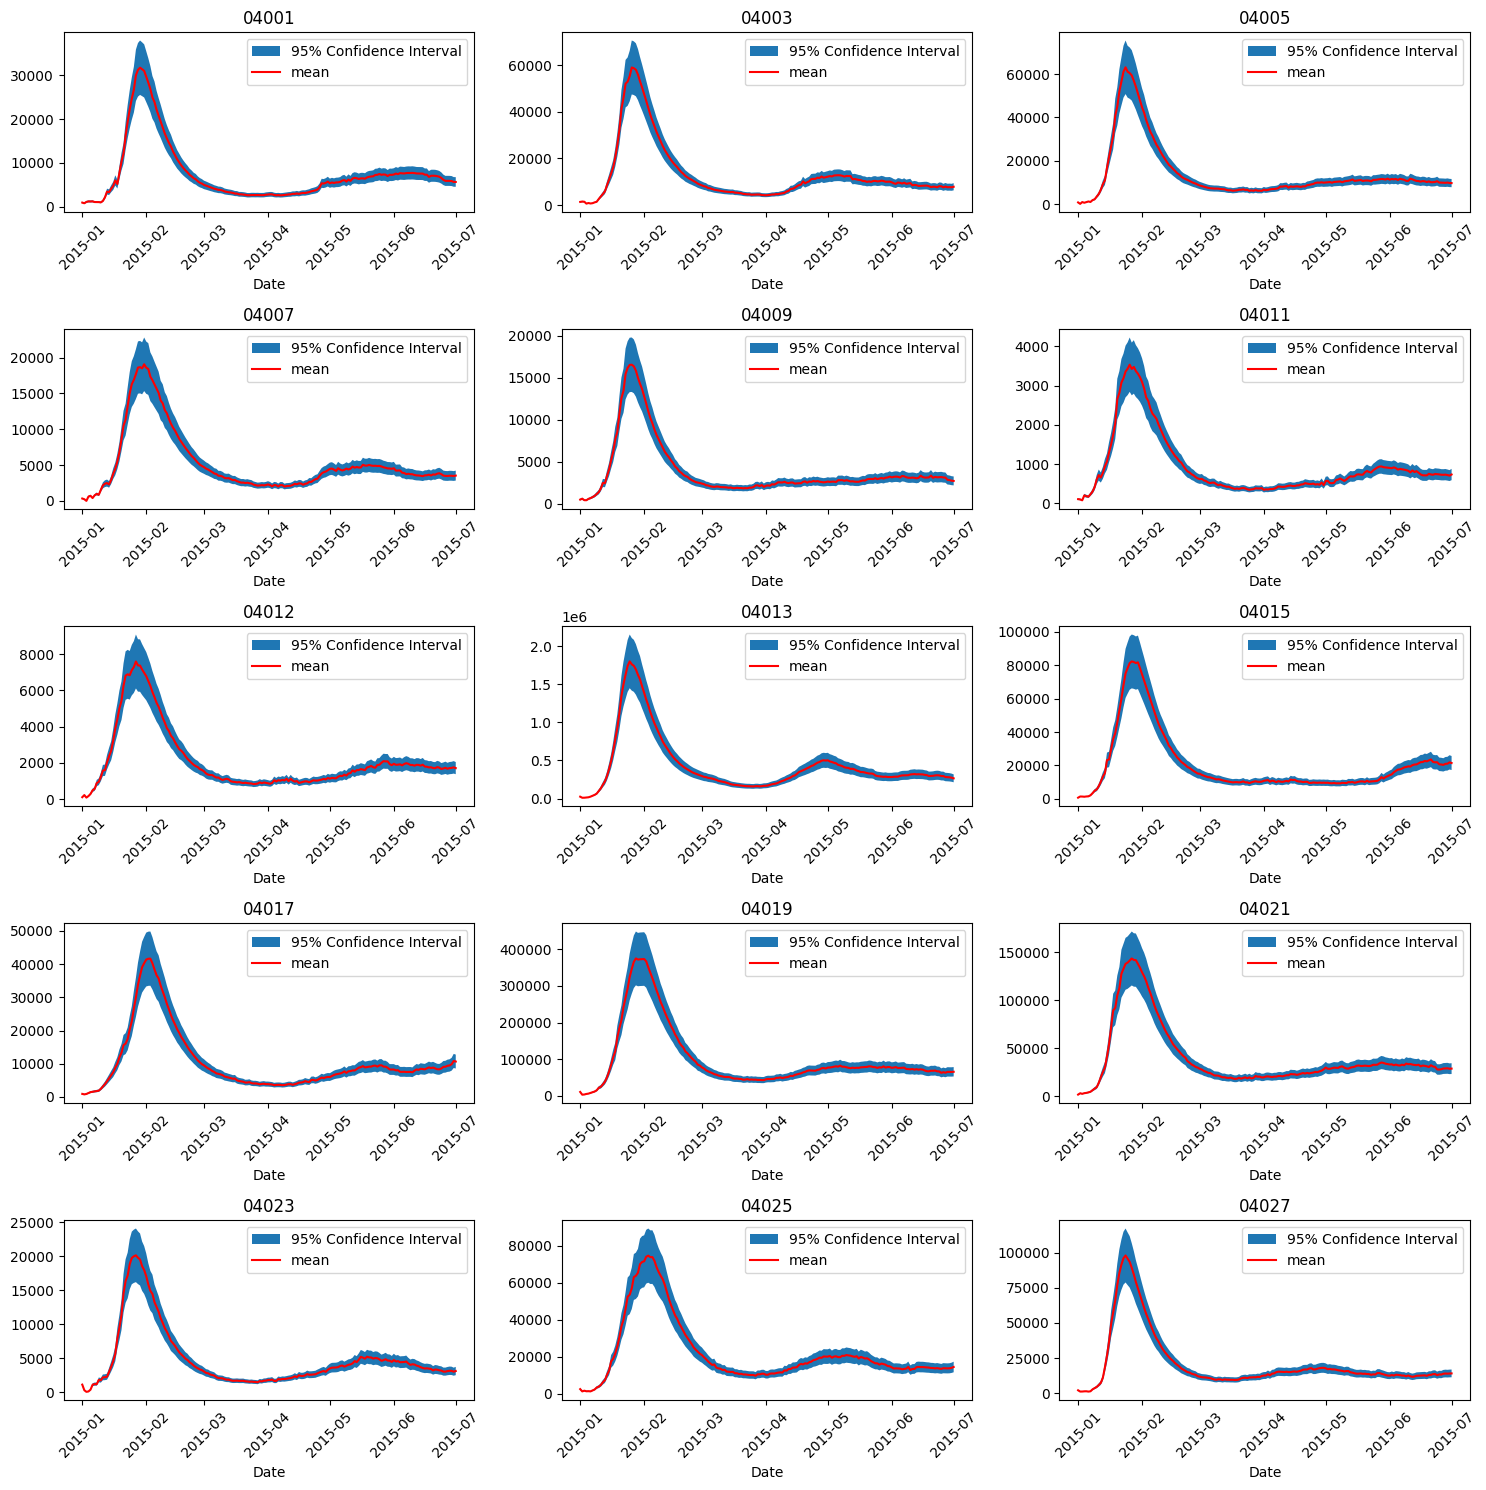

In [179]:
import math

num_nodes = inf_rume.scope.nodes
labels = inf_rume.scope.labels


cols = 3 
rows = math.ceil(num_nodes / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 5, rows * 3)
)

axes = axes.flatten()
for i, (geo, gdf) in enumerate(data_df.groupby("geo", sort=False)):

    CI = 1.96 * gdf["I"]["mean"]/np.sqrt(num_realizations)
    axes[i].set_title(f'{str(geo)}')
    axes[i].fill_between(gdf["time"],gdf["I"]["mean"] - CI, gdf["I"]["mean"] + CI,label = '95% Confidence Interval')
    axes[i].plot(gdf["time"], gdf["I"]["mean"], label='mean',color = 'red')
    axes[i].tick_params(axis = 'x',labelrotation = 45)
    axes[i].set_xlabel('Date')
    axes[i].legend()

fig.tight_layout()
